# Deep Markov Model inferred using SteinVI

https://num.pyro.ai/en/stable/examples/stein_dmm.html

In [1]:
import argparse

import numpy as np

import jax
from jax import nn, numpy as jnp, random
from optax import adam, chain

import numpyro
from numpyro.contrib.einstein import SteinVI
from numpyro.contrib.einstein.mixture_guide_predictive import MixtureGuidePredictive
from numpyro.contrib.einstein.stein_kernels import RBFKernel
import numpyro.distributions as dist
from numpyro.examples.datasets import JSB_CHORALES, load_dataset
from numpyro.optim import optax_to_numpyro

In [2]:
subsample_size = 10
max_iter = 100
repulsion = 1.0
verbose = True
num_stein_particles = 5
num_elbo_particles = 5
progress_bar = True
gru_dim = 150
rng_key = 142
device = "cpu" # "cpu"
rng_seed = 142
numpyro.set_platform(device)

In [3]:
def _reverse_padded(padded, lengths):
    def _reverse_single(p, length):
        new = jnp.zeros_like(p)
        reverse = jnp.roll(p[::-1], length, axis=0)
        return new.at[:].set(reverse)

    return jax.vmap(_reverse_single)(padded, lengths)


def load_data(split="train"):
    _, fetch = load_dataset(JSB_CHORALES, split=split)
    lengths, seqs = fetch(0)
    return (seqs, _reverse_padded(seqs, lengths), lengths)

In [4]:
def emitter(x, params):
    """Parameterizes the bernoulli observation likelihood `p(x_t | z_t)`"""
    l1 = nn.relu(jnp.matmul(x, params["l1"]))
    l2 = nn.relu(jnp.matmul(l1, params["l2"]))
    return jnp.matmul(l2, params["l3"])


def transition(x, params):
    """Parameterizes the gaussian latent transition probability `p(z_t | z_{t-1})`
    See section 5 in [1].

    **Reference:**
        1. Structured Inference Networks for Nonlinear State Space Models [arXiv:1609.09869]
        Rahul G. Krishnan, Uri Shalit and David Sontag (2016)
    """

    def _gate(x, params):
        l1 = nn.relu(jnp.matmul(x, params["l1"]))
        return nn.sigmoid(jnp.matmul(l1, params["l2"]))

    def _shared(x, params):
        l1 = nn.relu(jnp.matmul(x, params["l1"]))
        return jnp.matmul(l1, params["l2"])

    def _mean(x, params):
        return jnp.matmul(x, params["l1"])

    def _std(x, params):
        l1 = jnp.matmul(nn.relu(x), params["l1"])
        return nn.softplus(l1)

    gt = _gate(x, params["gate"])
    ht = _shared(x, params["shared"])
    loc = (1 - gt) * _mean(x, params["mean"]) + gt * ht
    std = _std(ht, params["std"])
    return loc, std


def combiner(x, params):
    mean = jnp.matmul(x, params["mean"])
    std = nn.softplus(jnp.matmul(x, params["std"]))
    return mean, std

In [7]:
def gru(xs, lengths, init_hidden, params):
    """RNN with GRU. Based on https://github.com/google/jax/pull/2298"""

    def apply_fun_single(state, inputs):
        i, x = inputs
        inp_update = jnp.matmul(x, params["update_in"])
        hidden_update = jnp.dot(state, params["update_weight"])
        update_gate = nn.sigmoid(inp_update + hidden_update)
        reset_gate = nn.sigmoid(
            jnp.matmul(x, params["reset_in"]) + jnp.dot(state, params["reset_weight"])
        )
        output_gate = update_gate * state + (1 - update_gate) * jnp.tanh(
            jnp.matmul(x, params["out_in"])
            + jnp.dot(reset_gate * state, params["out_weight"])
        )
        hidden = jnp.where((i < lengths)[:, None], output_gate, jnp.zeros_like(state))
        return hidden, hidden

    init_hidden = jnp.broadcast_to(init_hidden, (xs.shape[1], init_hidden.shape[1]))
    return jax.lax.scan(apply_fun_single, init_hidden, (jnp.arange(xs.shape[0]), xs))


def _normal_init(*shape):
    return lambda rng_key: dist.Normal(scale=0.1).sample(rng_key, shape)

In [8]:
def model(
    seqs,
    seqs_rev,
    lengths,
    *,
    subsample_size=10, #77,
    latent_dim=32,
    emission_dim=100,
    transition_dim=200,
    data_dim=88,
    gru_dim=150,
    annealing_factor=1.0,
    predict=False,
):
    max_seq_length = seqs.shape[1]

    emitter_params = {
        "l1": numpyro.param("emitter_l1", _normal_init(latent_dim, emission_dim)),
        "l2": numpyro.param("emitter_l2", _normal_init(emission_dim, emission_dim)),
        "l3": numpyro.param("emitter_l3", _normal_init(emission_dim, data_dim)),
    }

    trans_params = {
        "gate": {
            "l1": numpyro.param("gate_l1", _normal_init(latent_dim, transition_dim)),
            "l2": numpyro.param("gate_l2", _normal_init(transition_dim, latent_dim)),
        },
        "shared": {
            "l1": numpyro.param("shared_l1", _normal_init(latent_dim, transition_dim)),
            "l2": numpyro.param("shared_l2", _normal_init(transition_dim, latent_dim)),
        },
        "mean": {"l1": numpyro.param("mean_l1", _normal_init(latent_dim, latent_dim))},
        "std": {"l1": numpyro.param("std_l1", _normal_init(latent_dim, latent_dim))},
    }

    z0 = numpyro.param(
        "z0", lambda rng_key: dist.Normal(0, 1.0).sample(rng_key, (latent_dim,))
    )
    z0 = jnp.broadcast_to(z0, (subsample_size, 1, latent_dim))
    with numpyro.plate(
        "data", seqs.shape[0], subsample_size=subsample_size, dim=-1
    ) as idx:
        if subsample_size == seqs.shape[0]:
            seqs_batch = seqs
            lengths_batch = lengths
        else:
            seqs_batch = seqs[idx]
            lengths_batch = lengths[idx]

        masks = jnp.repeat(
            jnp.expand_dims(jnp.arange(max_seq_length), axis=0), subsample_size, axis=0
        ) < jnp.expand_dims(lengths_batch, axis=-1)
        # NB: Mask is to avoid scoring 'z' using distribution at this point
        z = numpyro.sample(
            "z",
            dist.Normal(0.0, jnp.ones((max_seq_length, latent_dim)))
            .mask(False)
            .to_event(2),
        )

        z_shift = jnp.concatenate([z0, z[:, :-1, :]], axis=-2)
        z_loc, z_scale = transition(z_shift, params=trans_params)

        with numpyro.handlers.scale(scale=annealing_factor):
            # Actually score 'z'
            numpyro.sample(
                "z_aux",
                dist.Normal(z_loc, z_scale)
                .mask(jnp.expand_dims(masks, axis=-1))
                .to_event(2),
                obs=z,
            )

        emission_probs = emitter(z, params=emitter_params)
        if predict:
            tunes = None
        else:
            tunes = seqs_batch
        numpyro.sample(
            "tunes",
            dist.Bernoulli(logits=emission_probs)
            .mask(jnp.expand_dims(masks, axis=-1))
            .to_event(2),
            obs=tunes,
        )

In [9]:
# Illustrating model function


In [10]:
# subsample_size = 10
# max_iter = 100
# repulsion = 1.0
# verbose = True
# num_stein_particles = 5
# num_elbo_particles = 5
# progress_bar = True
# gru_dim = 150
# rng_key = 142
# device = "METAL" # "cpu"
# rng_seed = 142

def guide(
    seqs,
    seqs_rev,
    lengths,
    *,
    subsample_size=10, #77,
    latent_dim=32,
    emission_dim=100,
    transition_dim=200,
    data_dim=88,
    gru_dim=150,
    annealing_factor=1.0,
    predict=False,
):
    max_seq_length = seqs.shape[1]
    seqs_rev = jnp.transpose(seqs_rev, axes=(1, 0, 2))

    combiner_params = {
        "mean": numpyro.param("combiner_mean", _normal_init(gru_dim, latent_dim)),
        "std": numpyro.param("combiner_std", _normal_init(gru_dim, latent_dim)),
    }

    gru_params = {
        "update_in": numpyro.param("update_in", _normal_init(data_dim, gru_dim)),
        "update_weight": numpyro.param("update_weight", _normal_init(gru_dim, gru_dim)),
        "reset_in": numpyro.param("reset_in", _normal_init(data_dim, gru_dim)),
        "reset_weight": numpyro.param("reset_weight", _normal_init(gru_dim, gru_dim)),
        "out_in": numpyro.param("out_in", _normal_init(data_dim, gru_dim)),
        "out_weight": numpyro.param("out_weight", _normal_init(gru_dim, gru_dim)),
    }

    with numpyro.plate(
        "data", seqs.shape[0], subsample_size=subsample_size, dim=-1
    ) as idx:
        if subsample_size == seqs.shape[0]:
            seqs_rev_batch = seqs_rev
            lengths_batch = lengths
        else:
            seqs_rev_batch = seqs_rev[:, idx, :]
            lengths_batch = lengths[idx]

        masks = jnp.repeat(
            jnp.expand_dims(jnp.arange(max_seq_length), axis=0), subsample_size, axis=0
        ) < jnp.expand_dims(lengths_batch, axis=-1)

        h0 = numpyro.param(
            "h0",
            lambda rng_key: dist.Normal(0.0, 1).sample(rng_key, (1, gru_dim)),
        )
        _, hs = gru(seqs_rev_batch, lengths_batch, h0, gru_params)
        hs = _reverse_padded(jnp.transpose(hs, axes=(1, 0, 2)), lengths_batch)
        with numpyro.handlers.scale(scale=annealing_factor):
            numpyro.sample(
                "z",
                dist.Normal(*combiner(hs, combiner_params))
                .mask(jnp.expand_dims(masks, axis=-1))
                .to_event(2),
            )

In [11]:
def vis_tune(i, tunes, lengths, name="stein_dmm.pdf"):
    tune = tunes[i, : lengths[i]]
    try:
        from music21.chord import Chord
        from music21.pitch import Pitch
        from music21.stream import Stream

        stream = Stream()
        for chord in tune:
            stream.append(
                Chord(list(Pitch(pitch) for pitch in (np.arange(88) + 21)[chord > 0]))
            )
        plot = stream.plot(doneAction=None)
        plot.write(name)
    except ModuleNotFoundError:
        import matplotlib.pyplot as plt

        plt.imshow(tune.T, cmap="Greys")
        plt.ylabel("Pitch")
        plt.xlabel("Offset")
        plt.savefig(name)

In [12]:
inf_key, pred_key = random.split(random.PRNGKey(seed=rng_seed), 2)

Metal device set to: Apple M3 Max

systemMemory: 48.00 GB
maxCacheSize: 18.00 GB



W0000 00:00:1736755442.870266  411947 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1736755442.885532  411947 service.cc:145] XLA service 0x107d25880 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736755442.885548  411947 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1736755442.886842  411947 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1736755442.886855  411947 mps_client.cc:384] XLA backend will use up to 38654230528 bytes on device 0 for SimpleAllocator.


In [13]:
inf_key

Array([1331912573, 1669068870], dtype=uint32)

In [14]:
pred_key

Array([ 204305305, 2353755994], dtype=uint32)

In [15]:
model

<function __main__.model(seqs, seqs_rev, lengths, *, subsample_size=10, latent_dim=32, emission_dim=100, transition_dim=200, data_dim=88, gru_dim=150, annealing_factor=1.0, predict=False)>

In [16]:
steinvi = SteinVI(
    model,
    guide,
    optax_to_numpyro(chain(adam(1e-2))),
    RBFKernel(),
    num_elbo_particles=num_elbo_particles,
    num_stein_particles=num_stein_particles,
)

In [17]:
seqs, rev_seqs, lengths = load_data()
results = steinvi.run(
    inf_key,
    max_iter,
    seqs,
    rev_seqs,
    lengths,
    gru_dim=gru_dim,
    subsample_size=subsample_size,
)

  0%|          | 0/100 [00:00<?, ?it/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
100%|██████████| 100/100 [01:47<00:00,  1.08s/it, Stein force 5290.68.]


In [18]:
results.params

{'combiner_mean': Array([[[-1.91608518e-02,  5.43616749e-02, -1.48114655e-03, ...,
           8.16848874e-02,  3.83953452e-02, -2.66228430e-02],
         [ 2.85889488e-02, -1.44957557e-01,  2.30562285e-01, ...,
          -4.66682278e-02,  2.63819732e-02,  2.63164882e-02],
         [ 8.95328671e-02,  4.13135486e-03,  9.51643139e-02, ...,
          -6.26076162e-02, -6.62950042e-05, -2.13878930e-01],
         ...,
         [ 6.32962259e-03,  9.85779893e-03, -4.85365801e-02, ...,
           5.80922849e-02,  1.88989013e-01, -5.59763648e-02],
         [ 3.49196307e-02,  6.23042211e-02,  1.88507855e-01, ...,
           1.70019180e-01, -1.90115825e-03,  2.42690459e-01],
         [ 1.65490136e-02, -2.85853799e-02, -2.50664800e-01, ...,
          -1.20486565e-01, -3.11878417e-02,  1.55706331e-01]],
 
        [[ 5.04812784e-02,  1.41350413e-02, -9.89467725e-02, ...,
          -6.59615174e-02, -4.59282584e-02,  5.38497381e-02],
         [ 3.81442271e-02, -4.38083559e-02,  2.82495096e-02, ...,
    

In [19]:
pred = MixtureGuidePredictive(
    model,
    guide,
    params=results.params,
    num_samples=1,
    guide_sites=steinvi.guide_sites,
)

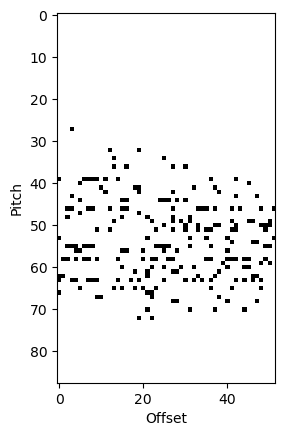

In [20]:
seqs, rev_seqs, lengths = load_data("valid")
pred_notes = pred(
    pred_key, seqs, rev_seqs, lengths, subsample_size=seqs.shape[0], predict=True
)["tunes"]

vis_tune(0, pred_notes[0], lengths)

In [21]:
pred_notes

Array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        ...,

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
    